# Trabajo Final Inteligencia Artificial I - año 2018: Visión Artificial
---

# [Dependencias y resultados previos](./01-representacion.ipynb)

## Dependencias

In [17]:
import numpy as np

from matplotlib import pyplot as plt
plt.rcParams['image.cmap'] = 'gray'

## Resultados

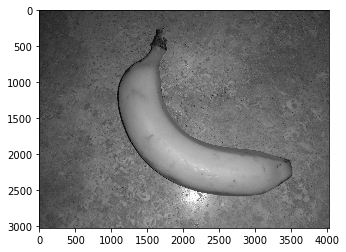

In [19]:
from skimage import io, color, img_as_float

img = io.imread('./imgs/examples/banana_example.jpg')
banana_float = img_as_float(img)

banana = color.rgb2gray(banana_float)

plt.imshow(banana)

---

# Filtrado de imagenes
---

El filtrado de las imágenes es importante porque ayudará a quitar el ruido de las fotografías de la base de datos y facilitará la posterior extracción de características de éstas. 

## Filtrado de señales de una dimensión

Partiendo de una señal escalón como la que sigue, con ayuda de la función _random_ de _numpy_, se añade ruido.

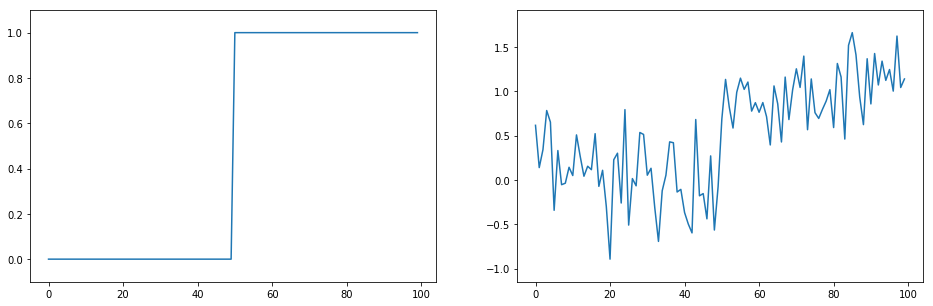

In [36]:
step_signal = np.zeros(100)
step_signal[50:] = 1
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 5))
ax0.plot(step_signal)
ax0.margins(y=0.1)

np.random.seed(0)

noisy_signal = (step_signal + np.random.normal(0, 0.35, step_signal.shape))
ax1.plot(noisy_signal);
ax1.margins(y=0.1)

Para filtrar el ruido de la señal, se utiliza lo que se denomina **kernel**. El kernel es un patrón determinado, por ejemplo en este caso podrías ser el promedio entre el valor de un determinado punto y sus vecinos, que se repite a lo largo de la señal. Esto es por medio de una función de **convolución**, que se aplica entre la señal de entrada y el kernel. 

### Filtro Gaussiano

Existe una gran cantidad de kernels posibles. Para éste caso se realiza un **filtro Gaussiano**, que se considera óptimo. Ésto debido a que le da gran peso a los vecinos cercanos al punto, y un menor peso a los lejanos.

El filtro Gaussiano para $\sigma=1$ está dado por:

$$
k_i = \frac{1}{\sqrt{2\pi}}\exp{\left(-\frac{(x_i - x_0)^2}{2}\right)}
$$

In [7]:
kernel = 1 / np.sqrt(2 * np.pi) * np.exp(-(np.arange(9) - 4)**2 / 2)

print(kernel)

[1.33830226e-04 4.43184841e-03 5.39909665e-02 2.41970725e-01
 3.98942280e-01 2.41970725e-01 5.39909665e-02 4.43184841e-03
 1.33830226e-04]


Para aplicar el kernel se utiliza el módulo _convolve_ de la librería _scipy.ndimage_:

In [8]:
from scipy.ndimage import convolve

El resultado será:

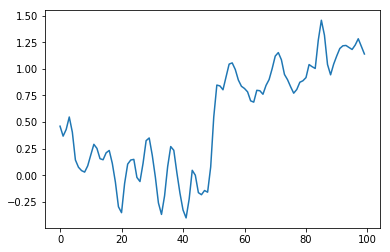

In [9]:
smooth_signal = convolve(noisy_signal, kernel, mode='reflect')
fig, ax = plt.subplots()
ax.plot(smooth_signal)

Como puede observarse, la señal es bastante más suave que la original.

### Filtro diferencial

Algo que será útil más adelante es observar las variaciones en la señal. Para ésto, se utiliza un **filtro diferencial**, que se logra utilizando un kernel de la forma:

In [10]:
kernel_diff = [1, 0, -1]

Su dinámica puede apreciarse más claramente si aplicamos este filtro a la señal escalón sin ruido:

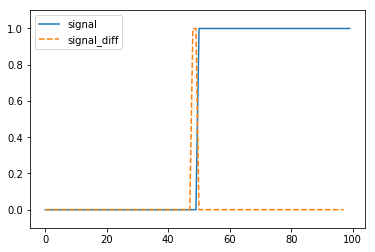

In [11]:
signal_diff = np.convolve(step_signal, kernel_diff, mode='valid')

fig, ax = plt.subplots()
ax.plot(step_signal, label='signal')
ax.plot(signal_diff, linestyle='dashed', label='signal_diff')
ax.legend(loc='upper left')
ax.margins(y=0.1)

### Señal resultante

Si aplicamos ambos kernels, el del filtro Gaussiano y el filtro diferencial, podemos obtener una señal que nos brinda información de los cambios importantes en la señal con ruido:

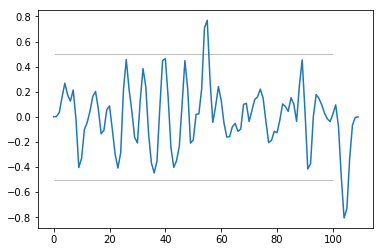

In [12]:
aux = np.convolve(kernel, kernel_diff, mode='full')
result = np.convolve(noisy_signal, aux)

fig, ax = plt.subplots()
ax.plot(result)
ax.hlines([-0.5, 0.5], 0, 100, linewidth=0.5, color='gray');

Es notable cómo en la señal obtenida, hay un pico en 50 donde se produce el escalón en la señal original.

## Extensión a imágenes (dos dimensiones)

El análisis para imágenes, donde se trabaja con dos dimensiones, es análogo. El kernel en lugar de ser un array, será una matriz.

### Filtro Gaussiano

El filtro Gaussiano es similar que para el caso 1D, se obtiene de la forma:

$$
k_{r, c} = \frac{1}{2\pi \sigma^2} \exp{\left(-\frac{r^2 + c^2}{2\sigma^2}\right)}
$$

Donde $r$ son el número de filas desde el centro y $c$ el número de columnas desde el centro.

Para obtener este filtro se utiliza el módulo de filtros de la librería _skimage_:

In [13]:
from skimage import filters

Una forma simple de visualizar la forma del kernel es aplicarlo sobre un punto.

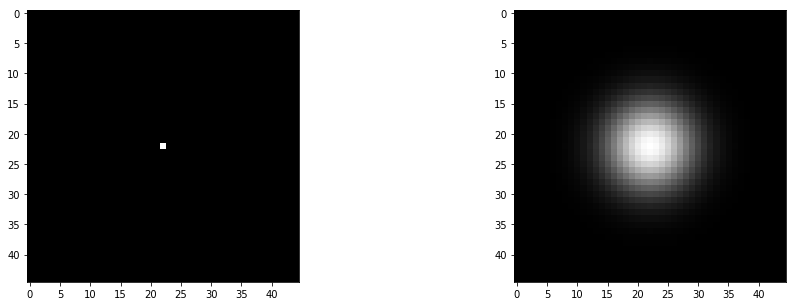

In [14]:
sidelen = 45
sigma = (sidelen - 1) // 2 // 4

spot = np.zeros((sidelen, sidelen), dtype=float)
spot[sidelen // 2, sidelen // 2] = 1

kernel2D = filters.gaussian(spot, sigma=sigma)

f, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 5))
ax0.imshow(spot)
ax1.imshow(kernel2D/np.max(kernel2D))

Para entender su funcionamiento, a continuación se aplica este filtro a una imagen genérica para observar resultados: 

Text(0.5,1,'filtrado')

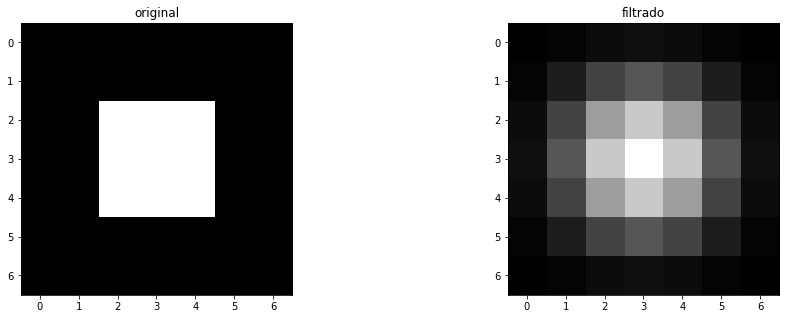

In [15]:
bright_square = np.zeros((7, 7), dtype=float)
bright_square[2:5, 2:5] = 1

sigma = 1
smooth = filters.gaussian(bright_square, sigma)

f, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 5))
ax0.imshow(bright_square)
ax0.set_title('original')
ax1.imshow(smooth)
ax1.set_title('filtrado')

Si se aplica este filtro Gaussiano sobre la imagen en escala de grises de la banana, se obtiene el siguiente resultado:

Text(0.5,1,'$\\sigma=50$')

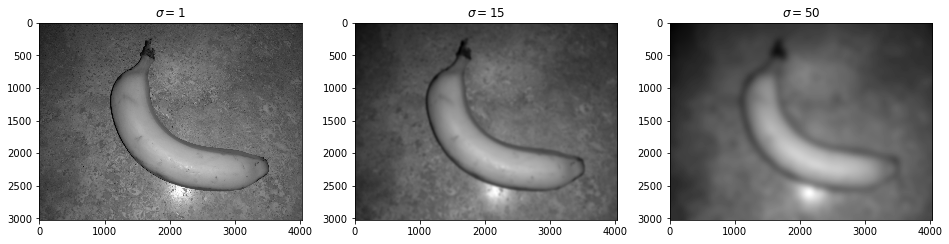

In [20]:
bs0 = filters.gaussian(banana, sigma=1)
bs1 = filters.gaussian(banana, sigma=15)
bs2 = filters.gaussian(banana, sigma=50)

f, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 5))
ax0.imshow(bs0)
ax0.set_title('$\sigma=1$')
ax1.imshow(bs1)
ax1.set_title('$\sigma=15$')
ax2.imshow(bs2)
ax2.set_title('$\sigma=50$')

Puede observarse que si $\sigma$ aumenta demasiado, la imagen comienza a hacerse borrosa.

### Filtro diferencial

El filtro diferencial, como se mencionó anteriormente, es de gran utilidad en imagenes, ya que permite la detección de límites entre luz y sombra, es decir, bordes de la imagen.

La diferencia con el caso 1D, es que ahora es necesario aplicar el filtro en dos direcciones: horizontal y vertical, a modo de gradientes. Por lo tanto los dos kernels serán:

In [22]:
vertical_kernel = np.array([
    [1, 1, 1],
    [0, 0, 0],
    [-1, -1, -1]
])

horizontal_kernel = vertical_kernel.T

Como puede observarse, por lógica, el kernel horizontal es el vertical transpuesto.

Si estos filtros se aplican a la imagen genérica anterior:

Text(0.5,1,'kernel vertical')

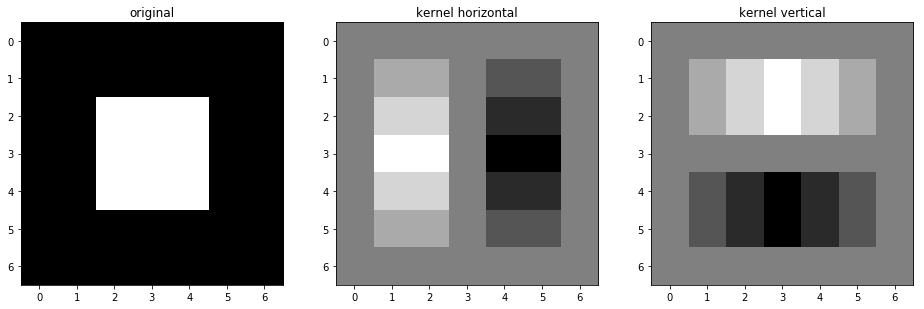

In [23]:
horizontal_gradient = convolve(bright_square.astype(float), horizontal_kernel)
vertical_gradient = convolve(bright_square.astype(float), vertical_kernel)

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 5))
ax0.imshow(bright_square)
ax0.set_title('original')
ax1.imshow(horizontal_gradient)
ax1.set_title('kernel horizontal')
ax2.imshow(vertical_gradient)
ax2.set_title('kernel vertical')

Si trigonométricamente se componen las dos direcciones ortogonales, se obtiene lo siguiente:

Text(0.5,1,'filtro diferencial, composición')

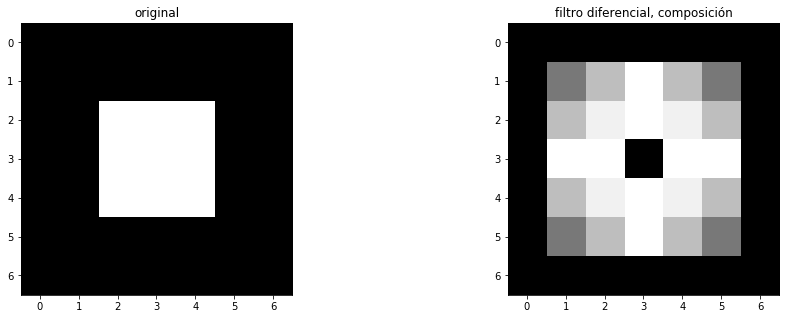

In [24]:
gradient = np.sqrt(horizontal_gradient**2 + vertical_gradient**2)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 5))
ax0.imshow(bright_square)
ax0.set_title('original')
ax1.imshow(gradient)
ax1.set_title('filtro diferencial, composición')

### Filtro Sobel

Utilizando el filtro de bordes Sobel, que utiliza un kernel (horizontal) como el siguiente:

In [25]:
kernel_sobel = np.array([
    [1, 0, -1],
    [2, 0, -2],
    [1, 0, -1]
])

Se obtienen resultados similares a los obtenidos para la composición del filtro diferencial en las dos direcciones. Por ejemplo, para la imagen genérica se obtiene lo siguiente:

Text(0.5,1,'filtrado con sobel')

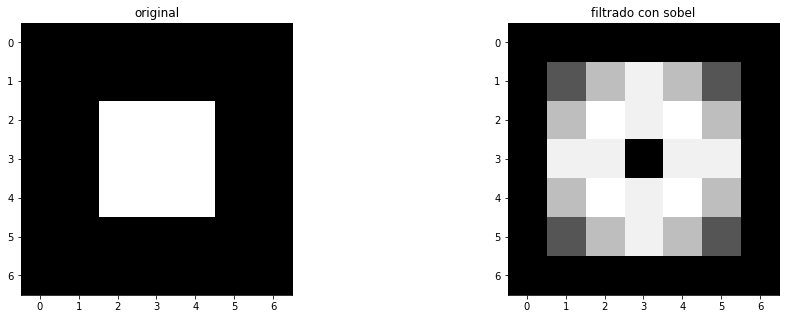

In [26]:
square_sobel = filters.sobel(bright_square)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 5))
ax0.imshow(bright_square)
ax0.set_title('original')
ax1.imshow(square_sobel)
ax1.set_title('filtrado con sobel')

### Filtro "Median"

Es otro tipo de filtro que se aplicaría en lugar del filtro Gaussiano. La ventaja según la documentación de _scikit-learn_, es que este filtro conserva mejor los bordes (característica muy importante para este trabajo). A continuación se aplica este filtro para poder comparar resultados luego: 

Text(0.5,1,'$r=10$')

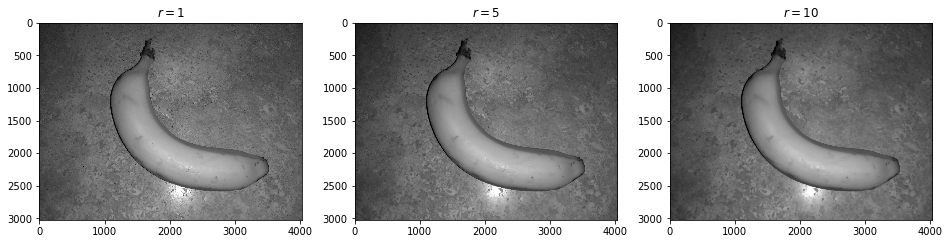

In [30]:
from skimage.morphology import disk

n0 = disk(radius=1)
n1 = disk(radius=5)
n2 = disk(radius=10)

bm0 = filters.rank.median(banana, n0)
bm1 = filters.rank.median(banana, n1)
bm2 = filters.rank.median(banana, n2)

f, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 5))
ax0.imshow(bm0)
ax0.set_title('$r=1$')
ax1.imshow(bm1)
ax1.set_title('$r=5$')
ax2.imshow(bm2)
ax2.set_title('$r=10$')

### Resultados

Si se aplica el filtro Gaussiano y el filtro Sobel a la imagen en escala de grises de la banana, se obtienen los siguientes resultados:

Text(0.5,1,'filtrado con median y sobel')

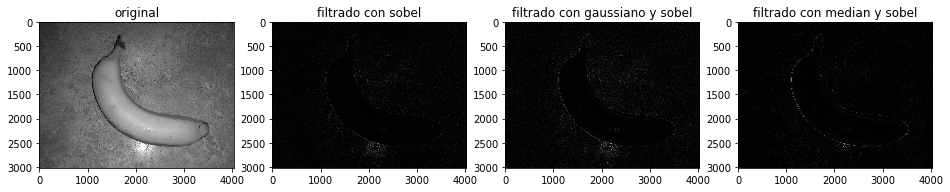

In [32]:
banana_sobel = filters.sobel(banana)
banana_gaussobel = filters.sobel(bs0)
banana_medsobel = filters.sobel(bm2)

fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(16, 5))
ax0.imshow(banana)
ax0.set_title('original')
ax1.imshow(banana_sobel)
ax1.set_title('filtrado con sobel')
ax2.imshow(banana_gaussobel)
ax2.set_title('filtrado con gaussiano y sobel')
ax3.imshow(banana_medsobel)
ax3.set_title('filtrado con median y sobel')

En la última comparativa puede notarse lo fundamental del filtro Gaussiano, ya que luego de éste y el filtro Sobel, el contorno de la banana es mucho más marcado.

Concluído que el filtro Gaussiano es necesario, se procede a realizar una comparativa entre filtros Gaussianos con diferentes $\sigma$ y un posterior filtro Sobel:

Text(0.5,1,'$\\sigma=40$')

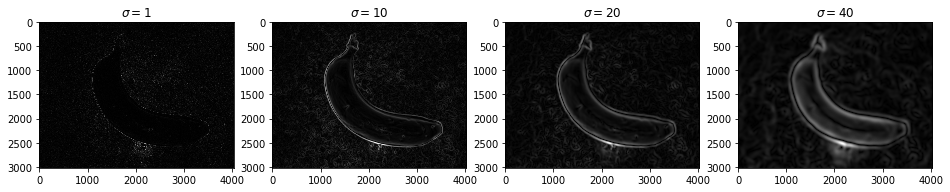

In [28]:
bs0 = filters.gaussian(banana, sigma=1)
bs1 = filters.gaussian(banana, sigma=10)
bs2 = filters.gaussian(banana, sigma=20)
bs3 = filters.gaussian(banana, sigma=40)

bsobel0 = filters.sobel(bs0)
bsobel1 = filters.sobel(bs1)
bsobel2 = filters.sobel(bs2)
bsobel3 = filters.sobel(bs3)

fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(16, 5))
ax0.imshow(bsobel0)
ax0.set_title('$\sigma=1$')
ax1.imshow(bsobel1)
ax1.set_title('$\sigma=10$')
ax2.imshow(bsobel2)
ax2.set_title('$\sigma=20$')
ax3.imshow(bsobel3)
ax3.set_title('$\sigma=40$')

Dado los resultados anteriores, se podría estimar que no es necesario un $\sigma$ mayor a 10 en el filtro Gaussiano.

A continuación se realiza el mismo análisis pero para filtro "median", con el fin de elegir el más adecuado al problema.

Text(0.5,1,'$r=100$')

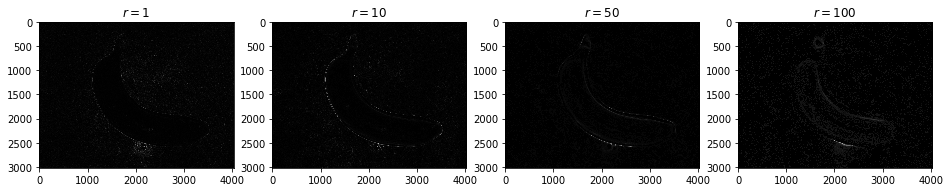

In [35]:
n0 = disk(radius=1)
n1 = disk(radius=10)
n2 = disk(radius=50)
n3 = disk(radius=100)

bm0 = filters.rank.median(banana, n0)
bm1 = filters.rank.median(banana, n1)
bm2 = filters.rank.median(banana, n2)
bm3 = filters.rank.median(banana, n3)


bsobel0 = filters.sobel(bm0)
bsobel1 = filters.sobel(bm1)
bsobel2 = filters.sobel(bm2)
bsobel3 = filters.sobel(bm3)

fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(16, 5))
ax0.imshow(bsobel0)
ax0.set_title('$r=1$')
ax1.imshow(bsobel1)
ax1.set_title('$r=10$')
ax2.imshow(bsobel2)
ax2.set_title('$r=50$')
ax3.imshow(bsobel3)
ax3.set_title('$r=100$')

Como puede observarse, con el filtro "median" no se obtienen mejores resultados que con el filtro Gaussiano. Sin embargo, no se descarta que más adelante sea necesario.